<a href="https://colab.research.google.com/github/dots13/fake_news_detection_Salvador/blob/master/MDFEND/LDA_model_domains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

import joblib

In [2]:
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/files/fake-news'

Mounted at /content/gdrive


In [3]:
df = pd.read_parquet(path + "/fake_news_unif_2.parquet")

In [4]:
df.head()

,fake_news_class,topic,headline,text,date,source,link,df_origen
0,0,politics,Moreno intenta apaciguar el flanco sanitario m...,El presidente abre la puerta a unos comicios e...,2022-04-19,None,None,politics_fake_news.csv
1,0,politics,La Abogacía del Estado se retira como acusació...,"En un escrito, la abogada del Estado Rosa Marí...",2021-09-17,None,None,politics_fake_news.csv
2,1,politics,Las promesas incumplidas de Pablo Echenique en...,Este lunes y martes la Asamblea de Madrid acog...,2022-09-12,None,None,politics_fake_news.csv
3,0,politics,Sánchez defiende 'resolver el problema' de la ...,Resulta evidente que la ley ha tenido algunos ...,2023-02-07,None,None,politics_fake_news.csv
4,0,politics,Ian Gibson cierra la lista electoral de la con...,"El hispanista, que ya ocupó un puesto simbólic...",2023-04-12,None,None,politics_fake_news.csv


In [5]:
df.shape

(61372, 8)

In [6]:
df.fake_news_class.value_counts()/len(df)

0    0.577902
1    0.422098
Name: fake_news_class, dtype: float64

In [7]:
df.topic.value_counts()/len(df)

politics         0.932526
Politics         0.005263
Covid-19         0.003862
Sociedad         0.003177
Entertainment    0.002412
Society          0.002183
Sport            0.002020
Política         0.001743
Science          0.001450
Health           0.000750
Economy          0.000701
Security         0.000684
Education        0.000358
Internacional    0.000228
Ciencia          0.000212
Ambiental        0.000065
Deporte          0.000033
Name: topic, dtype: float64

In [8]:
def remove_duplicates(df, text_column):
    df_cleaned = df.drop_duplicates(subset=[text_column], keep='first')
    return df_cleaned

In [9]:
def check_duplicates(df, text_column):
    duplicate_rows = df[df.duplicated(subset=[text_column], keep=False)]
    if duplicate_rows.empty:
      print("No duplicates found.")
    else:
      print("Duplicates found.")

In [10]:
check_duplicates(df, 'text')

Duplicates found.


In [11]:
df.shape

(61372, 8)

In [12]:
df = remove_duplicates(df, 'text')
check_duplicates(df, 'text')
df.shape

No duplicates found.


(53655, 8)

In [13]:
df = df[['text', 'topic', 'fake_news_class']]

In [14]:
df_train, df_val = train_test_split(df,
                                    random_state=10,
                                    test_size=0.15,
                                    stratify=df['fake_news_class'])

In [15]:
print(df_train.shape)
print(df_val.shape)

(45606, 3)
(8049, 3)


**Domain Annotation.**  
According to the official paper https://dl.acm.org/doi/epdf/10.1145/3459637.3482139:  

*  After data collection, we perform categorization on crowd-sourcing.First, in order to work out the categorization criterion, we referto domain lists from several well-known fact-checking websites,including Zhuoyaoji [47], Liuyanbaike [21], Jiaozhen [13], and Rui-jianshiyao [32], as well as some research papers and reports, in-cluding Vosoughi et al. [38], 2017 Tencent Rumor Governance Re-port [37] and China Joint Internet Rumor-Busting Platform [29].Considering the congruence as well as the appropriateness of gran-ularity, we end with nine domains:**Science,Military,Education,Disasters,Politics,Health,Finance,Entertainment, and Society**. Then, we annotate all pieces of news into the above ninedomains. *

---




**LDA**  
Latent Dirichlet Allocation (LDA) is a generative probabilistic model used for topic modeling, a technique for discovering the underlying themes or topics present in a collection of text documents. LDA assumes that documents are made up of multiple topics, and each topic is characterized by a distribution of words.

https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

In [16]:
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
import numpy as np

import pandas as pd
from gensim.models import CoherenceModel, LdaModel
from gensim.corpora import Dictionary
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
from nltk.stem import SnowballStemmer

import copy
import re

In [17]:

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [18]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-ZáéíóúüÁÉÍÓÚÜÑñ\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token not in string.punctuation]
    # Remove stopwords
    stop_words = set(stopwords.words('spanish'))
    tokens = [token for token in tokens if token not in stop_words]
    # Stemming
    stemmer = SnowballStemmer('spanish')
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [20]:
df_train_copy = copy.deepcopy(df_train)
df_train_copy

,text,topic,fake_news_class
59309,Confirmado: Alan Pulido será el nuevo James Bo...,Entertainment,1
40984,"La relación del PP y Vox, que había sido más o...",politics,0
21060,Â¿Puede acabar el rey emérito procesado si fin...,politics,1
44585,El tribunal rechaza los recursos de la Fiscalí...,politics,0
37212,"Asegura que su antiguo colaborador, que la acu...",politics,0
...,...,...,...
761,El Ministerio Público considera que hay indici...,politics,1
41777,El segundo y último debate electoral enfrentó ...,politics,1
53232,El Congreso acoge un debate entre portavoces d...,politics,1
12765,"PNC, por su parte, califica de anomalía la ini...",politics,1


In [21]:
# Apply preprocessing to text column
df_train_copy['tokens'] = df_train_copy['text'].apply(preprocess_text)
dictionary = Dictionary(df_train_copy['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_train_copy['tokens']]

num_topics_range = range(3, 14)
coherence_scores = []
coherence_dic = {}

In [29]:
for num_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    coherence_model = CoherenceModel(model=lda_model, texts=df_train_copy['tokens'], dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_scores.append(coherence)
    coherence_dic[num_topics] = coherence
    print(f'Topics number: {num_topics}, coherence: {coherence}')

Topics number: 3, coherence: 0.3941213865594586
Topics number: 4, coherence: 0.38932284452574656
Topics number: 5, coherence: 0.419388705328602
Topics number: 6, coherence: 0.3995461521324211
Topics number: 7, coherence: 0.4173224186027629
Topics number: 8, coherence: 0.4097008008825033
Topics number: 9, coherence: 0.4255901261161277
Topics number: 10, coherence: 0.4369473219436853
Topics number: 11, coherence: 0.46017941178515803
Topics number: 12, coherence: 0.4270052556097892
Topics number: 13, coherence: 0.3921521006499193


In [30]:
max_topic = max(coherence_dic, key=coherence_dic.get)
print(max_topic)

11


In [31]:
print(f'Max coherence:{max(coherence_dic.values())}, max topics: {max(coherence_dic, key=coherence_dic.get)}')

Max coherence:0.46017941178515803, max topics: 11


In [32]:
# return a number of topic that was given by LDA
def label_document(text):
    tokens = preprocess_text(text)
    bow = dictionary.doc2bow(tokens)
    topic_distribution = lda_model.get_document_topics(bow)
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    return dominant_topic

In [ ]:
def save_lda_model(lda_model, dictionary, model_filename, dictionary_filename):
    #Save LDA model and dictionary
    joblib.dump(lda_model, model_filename)
    joblib.dump(dictionary, dictionary_filename)

In [ ]:
#model_filename = '/content/gdrive/My Drive/LDA/lda_model.pkl'
#dictionary_filename = '/content/gdrive/My Drive/LDA/dictionary.pkl'
#save_lda_model(lda_model, dictionary, model_filename, dictionary_filename)

In [44]:
lda_model = joblib.load('/content/gdrive/My Drive/LDA/lda_model.pkl')
dictionary = joblib.load('/content/gdrive/My Drive/LDA/dictionary.pkl')

In [45]:
#lda_model = LdaModel(corpus, num_topics=max_topic, id2word=dictionary)
df_train_copy['topic_new'] = df_train_copy['text'].apply(label_document)

In [46]:
 df_train_copy.groupby(['topic_new', 'topic']).count().reset_index()[:50]

,topic_new,topic,text,fake_news_class,tokens,text_length
0,0,Covid-19,1,1,1,1
1,0,Deporte,1,1,1,1
2,0,Politics,4,4,4,4
3,0,Política,2,2,2,2
4,0,Sociedad,6,6,6,6
5,0,Sport,1,1,1,1
6,0,politics,2698,2698,2698,2698
7,1,Sociedad,1,1,1,1
8,1,Society,1,1,1,1
9,1,politics,1696,1696,1696,1696


In [47]:
top_words_per_topic = lda_model.show_topics(num_topics=-1, num_words=15, formatted=False)

In [48]:
top_words_per_topic

[(0,
  [('años', 0.013625884),
   ('eur', 0.0134278955),
   ('tribunal', 0.011141174),
   ('millon', 0.010844739),
   ('conden', 0.0095288325),
   ('mes', 0.007980928),
   ('prision', 0.00660541),
   ('proces', 0.005940543),
   ('nuev', 0.005866032),
   ('sal', 0.005829538),
   ('recurs', 0.005383884),
   ('dos', 0.005211142),
   ('sentenci', 0.005099782),
   ('delit', 0.0049537225),
   ('decision', 0.0049407943)]),
 (1,
  [('madr', 0.011750957),
   ('delit', 0.011419697),
   ('barcelon', 0.0102263205),
   ('alcald', 0.009794574),
   ('public', 0.008952935),
   ('acus', 0.008371705),
   ('capital', 0.008162437),
   ('part', 0.007184733),
   ('acto', 0.006891084),
   ('organiz', 0.0067084637),
   ('consider', 0.0066323243),
   ('expresident', 0.006587963),
   ('maestr', 0.0064515923),
   ('cas', 0.0061735604),
   ('alfons', 0.0060623367)]),
 (2,
  [('numb', 0.020904884),
   ('hac', 0.0073024393),
   ('sol', 0.0066581997),
   ('pas', 0.006278501),
   ('si', 0.0061538666),
   ('años', 0.0

In [49]:
df_train_copy

,text,topic,fake_news_class,tokens,topic_new,text_length
59309,Confirmado: Alan Pulido será el nuevo James Bo...,Entertainment,1,"[confirm, alan, pul, nuev, jam, bond, despues,...",8,1313
40984,"La relación del PP y Vox, que había sido más o...",politics,0,"[relacion, pp, vox, sid, men, tranquil, hac, m...",6,231
21060,Â¿Puede acabar el rey emérito procesado si fin...,politics,1,"[pued, acab, rey, emerit, proces, si, final, d...",0,386
44585,El tribunal rechaza los recursos de la Fiscalí...,politics,0,"[tribunal, rechaz, recurs, fiscal, defens, pen...",0,95
37212,"Asegura que su antiguo colaborador, que la acu...",politics,0,"[asegur, antigu, colabor, acus, financi, ilega...",5,214
...,...,...,...,...,...,...
761,El Ministerio Público considera que hay indici...,politics,1,"[ministeri, public, consider, indici, portavoz...",5,229
41777,El segundo y último debate electoral enfrentó ...,politics,1,"[segund, ultim, debat, electoral, enfrent, nue...",4,274
53232,El Congreso acoge un debate entre portavoces d...,politics,1,"[congres, acog, debat, portavoc, fern, martine...",4,213
12765,"PNC, por su parte, califica de anomalía la ini...",politics,1,"[pnc, part, calif, anomal, inici, nuev, canari...",4,146


In [50]:
df_train_copy['text_length'] = df_train_copy['text'].apply(len)

In [51]:
df_train_copy.text_length.describe()

count    45606.000000
mean       327.341446
std        648.318633
min         33.000000
25%        178.000000
50%        228.000000
75%        283.000000
max      28179.000000
Name: text_length, dtype: float64

In [52]:
df_new = copy.deepcopy(df_train_copy[['text', 'topic_new', 'fake_news_class']])
df_new.rename(columns={'topic_new': 'domain'}, inplace=True)
df_new.rename(columns={'fake_news_class': 'label'}, inplace=True)
df_new.head()

,text,domain,label
59309,Confirmado: Alan Pulido será el nuevo James Bo...,8,1
40984,"La relación del PP y Vox, que había sido más o...",6,0
21060,Â¿Puede acabar el rey emérito procesado si fin...,0,1
44585,El tribunal rechaza los recursos de la Fiscalí...,0,0
37212,"Asegura que su antiguo colaborador, que la acu...",5,0


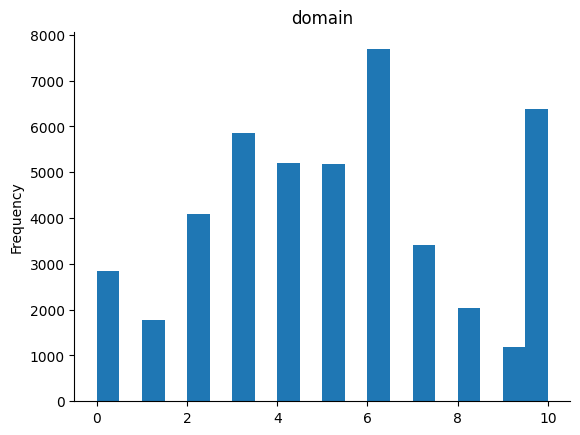

In [53]:
# @title domain

from matplotlib import pyplot as plt
df_new['domain'].plot(kind='hist', bins=20, title='domain')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [54]:
df_train, df_test = train_test_split(df_new,
                                    random_state=10,
                                    test_size=0.2,
                                    stratify=df_new['label'])

In [55]:
df_train.head()

,text,domain,label
19631,"El presidente del Gobierno, Pedro Sánchez, ha ...",3,0
30285,Los empleados han denunciado la cancelación de...,4,1
46847,El líder del PSOE ya ha mantenido contactos co...,4,0
39096,Los grupos políticos que se opusieron a que Ga...,6,0
25206,El presidente del Gobierno recuerda que el Eje...,10,0


In [56]:
print(df_train.shape)
print(df_test.shape)

(36484, 3)
(9122, 3)


In [57]:
df_val.rename(columns={'topic': 'domain'}, inplace=True)
df_val.rename(columns={'fake_news_class': 'label'}, inplace=True)

In [58]:
df_val['domain'] = df_val['text'].apply(label_document)

In [59]:
df_val.head()

,text,domain,label
40969,El ministro del Interior ha asegurado que llev...,5,0
22270,La hermana de Felipe VI ha sorteado las restri...,9,0
58123,Adal Ramones protagonizará el remake de El Cha...,2,1
54881,El instructor de la causa del procés inadmitió...,0,0
12526,Ignacio González señala al Partido Popular y a...,5,0


In [60]:
df_val.shape

(8049, 3)

In [61]:
df_train.to_json('/content/gdrive/My Drive/data_train_test_val_json/train_data.json', orient='records')
df_test.to_json('/content/gdrive/My Drive/data_train_test_val_json/test_data.json', orient='records')
df_val.to_json('/content/gdrive/My Drive/data_train_test_val_json/val_data.json', orient='records')